In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# BDD Iter3

C3.1.3 : Diagramme

Le diagramme manque d’une information clé: la multiplicité des associations. En équipe, retrouvez les multiplicités des associations suivantes:
    a. Agency - Routes -> 1..1 ------- 1..* (une route appartient forcément à une agence, une agence peut prendre une muliciplicité de routes et au moins une)
    b. Trips - StopTimes  -> 1..1 ------- 2..*
    c. StopTimes - Stops  -> 1..* ------- 1..1
    d. Trips - Calendar  -> 1..* ------- 1..* (ou 1..1 ?)
    e. Trips - Frequencies  -> 1..1 ------ 0..*   (ou 0..* ------- 0..1 ?)

C3.2 - Création d’un schéma

DROP TABLE IF EXISTS agency;
CREATE TABLE agency
(
    agency_id INT,
    agency_name TEXT,
    PRIMARY KEY  (agency_id)
);

DROP TABLE IF EXISTS routes;
CREATE TABLE routes
(
    route_id INT,
    agency_id INT,
    route_short_name TEXT,
    route_type INT,
    PRIMARY KEY (route_id),
    FOREIGN KEY (agency_id) REFERENCES agency(agency_id)
);

DROP TABLE IF EXISTS trips;
CREATE TABLE trips
(
    trip_id INT,
    trip_short_name TEXT,
    PRIMARY KEY (trip_id)
    -- cette ligne ne marche pas : FOREIGN KEY (route_id) REFERENCES routes(route_id)
);

DROP TABLE IF EXISTS stoptimes;
CREATE TABLE stoptimes
(
    trip_id INT,
    stop_id INT,
    arrival_time TIME,
    departure_time TIME,
    stop_sequence INT,
    PRIMARY KEY (trip_id, stop_id),
    FOREIGN KEY (trip_id) REFERENCES trips(trip_id),
    FOREIGN KEY (stop_id) REFERENCES stops(stop_id)
);

DROP TABLE IF EXISTS stops;
CREATE TABLE stops
(
    stop_id INT,
    stop_name TEXT,
    stop_lat REAL,
    stop_lon REAL,
    PRIMARY KEY (stop_id)
);

C3.3 - Insertion des données via Pandas

In [ ]:
import sqlite3
import pandas as pd

In [ ]:
# Create a DataFrame with all .txt
agency = pd.read_csv('./SEM-GTFS/agency.txt')
agency = agency.iloc[:,[0,1]]
agency

In [ ]:
routes = pd.read_csv('./SEM-GTFS/routes.txt')
routes = routes.iloc[:,[0,1,2,4]]
routes.head()

In [ ]:
stops = pd.read_csv('./SEM-GTFS/stops.txt')
stops = stops.iloc[:,[0,2,3,4]]
stops.head()

In [ ]:
stoptimes = pd.read_csv('./SEM-GTFS/stop_times.txt')
stoptimes = stoptimes.iloc[:,[0,1,2,3,4]]
stoptimes.head()

In [ ]:
trips = pd.read_csv('./SEM-GTFS/trips.txt')
trips = trips.iloc[:,[0,1,2]]
trips["trip_short_name"] = trips["trip_headsign"]
trips = trips.drop("trip_headsign",axis=1)
trips.head()

In [ ]:
gtfs = sqlite3.connect('./gtfs_tag.db')

In [ ]:
agency.to_sql('agency', con=gtfs, if_exists='append', index=False)

In [ ]:
routes.to_sql('routes', con=gtfs, if_exists='append', index=False)

In [ ]:
stops.to_sql('stops', con=gtfs, if_exists='append', index=False)

In [ ]:
stoptimes.to_sql('stoptimes', con=gtfs, if_exists='append', index=False)

In [ ]:
trips.to_sql('trips', con=gtfs, if_exists='append', index=False)

In [ ]:
gtfs.close()

C3.4 - Insertion des données (bulk insert)

In [ ]:
# bulk insert en python
#create dictionnaries from pd from txt
# agency_dict = agency.to_dict(orient='list')
# routes_dict = routes.to_dict(orient='list')
# stops_dict = stops.to_dict(orient='list')
# stoptimes_dict = stoptimes.to_dict(orient='list')
# trips_dict = trips.to_dict(orient='list')

In [ ]:
agency_dict = agency.T.reset_index().to_dict(orient='list')
routes_dict = routes.T.reset_index().to_dict(orient='list')
stops_dict = stops.T.reset_index().to_dict(orient='list')
stoptimes_dict = stoptimes.T.reset_index().to_dict(orient='list')
trips_dict = trips.T.reset_index().to_dict(orient='list')

In [ ]:
agency_dict

In [ ]:
# sans passé par Pandas
# a_dictionary = {}
# a_file = open("data.txt")
# for line in a_file:
#     key, value = line.split()
# Split line into a tuple
#     a_dictionary[key] = value
# Add tuple values to dictionary
# print(a_dictionary)

In [ ]:
# # return a single query from a dict
# def gen_insert_query(table_name:str, a_dict:dict) -> str:
#     columns = list(a_dict.keys())
#     features = ""
#     for col in columns:
#         features += f"{col},"
#     features = features[:-1]
#     values = "("
#     for col in columns:
#         values += "?,"
#     values = values[:-1]
#     values += ")"
#     return f'''INSERT INTO {table_name}({features}) VALUES{values}'''

Étape 3.4.1 - implémenter une fonction qui génère une commande insertion SQL

In [ ]:
# return a single query from a dict
def gen_insert_query(table_name:str, a_dict:dict) -> str:
    columns = a_dict['index']
    features = ""
    for col in columns:
        features += f"{col},"
    features = features[:-1]
    v=""
    for i in a_dict:
        if i!='index':
            values = "("
            for j in range(0,len(a_dict[i])):
                if isinstance(a_dict[i][j],str):
                    values += "'"
                    values += f"{a_dict[i][j]}"
                    values += "',"
                else:
                    values += f"{a_dict[i][j]},"
            values = values[:-1]
            values += ")"
            v+=values
            v+=','
    v = v[:-1]
    return f'''INSERT INTO {table_name}({features}) VALUES {v}'''

In [ ]:
gen_insert_query('routes', routes_dict)

In [ ]:
# on crée un agency_test
agency_dict_test={'index':['agency_id','agency_name'], 0:['TKM','Travel Kernel Mobility']}
gen_insert_query('agency', agency_dict_test)
# ça marche !

In [ ]:
gtfs = sqlite3.connect('./gtfs_tag.db')
c = gtfs.cursor()
c.execute(gen_insert_query('agency', agency_dict_test))
gtfs.commit()
# ça marche !

In [ ]:
gtfs.close()

Étape 3.4.2 - implémenter une fonction qui génère des commandes d’insertion SQL

In [ ]:
# return queries from a df
def gen_insert_queries(table_name:str, df: pd.DataFrame) -> list:
    return f"INSERT INTO {table_name}{tuple(df.columns.to_list())} VALUES {','.join(str(i) for i in tuple(zip(*df.to_dict(orient='list').values())))}"

In [ ]:
gen_insert_queries('trips', trips)
# ça marche !

Étape 3.4.3 - implémenter une procédure qui crée un fichier SQL

In [ ]:
def gen_insert_file(filename, tablename, df):
    with open(filename, "w") as fichier:
        fichier.write(gen_insert_queries(tablename, df))

In [ ]:
gen_insert_file('insert_trips.sql','trips',trips)
# ça marche !

In [ ]:
# on recrée un agency_test
agency_test=pd.DataFrame(data={"agency_id":["Data+"],"agency_name":["Directional Aerial Transportation Agency Plus"]})
agency_test

In [ ]:
gen_insert_file('insert_agency_test.sql','agency', agency_test)

Étape 3.4.4 – Exécutez votre fichier SQL sur la BDD

In [ ]:
gtfs = sqlite3.connect('./gtfs_tag.db')
c = gtfs.cursor()
with open('insert_agency_test.sql', "r") as fichier:  
    c.execute(fichier.read())
gtfs.commit()
gtfs.close()
# ça marche !

C3.5 - Réflexions

Vous avez inséré des données avec deux méthodes différentes (pandas, bulk Insert):
1. Quelle méthode est plus rapide et facile à implémenter ? <br/> **Pandas**
2. Quelle méthode est plus rapide pour insérer l’information ?  <br/> **Pandas**
3. Dans quel scénario préconisez-vous l’utilisation d’une méthode ou l’autre ?  <br/> **python pour tester pas à pas, Pandas '.to_sql' + sqlalchemy 'event' + python 'cursor.fast_executemany = True' pour deployer**
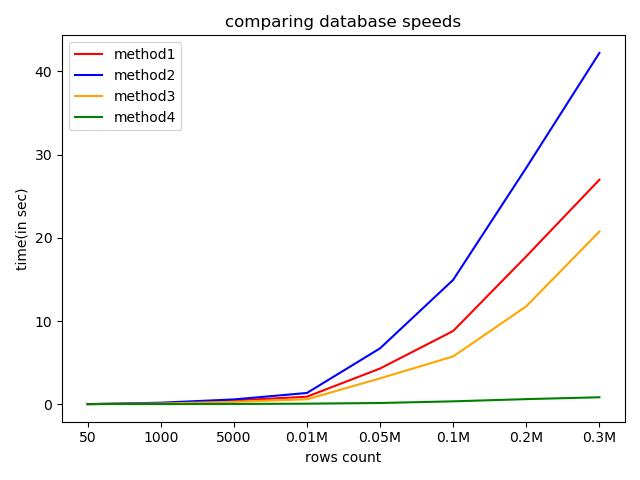

C3.6 -  (🕹 Bonus) Créer un calculateur d’itinéraire

À partir de :

• A - Un point GPS de départ, en format tuples de float; <br/> 
• B – Un point GPS d’arrivée, en format tuples de float; <br/>
• H – une heure de part en format datetime; <br/>

→ Calculez l’itinéraire des lignes TAG à prendre.

In [ ]:
from pyroutelib3 import Router
import folium
import webbrowser
from datetime import datetime
def calculateur_itineraire_ss_changement_plus_court(A,B,H):
    router = Router("car")
    # find closest stop x from A
    
    # rajouter A to x à l'itineraire
    depart = router.findNode(A[0], A[1])
    arrivee = router.findNode(B[0], B[1]) #pour tester
#(x[0], x[1])
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
        routeLatLons = list(map(router.nodeLatLon, route))
        
    # find closest stop y from B, in route that contains x and y
    
    # rajouter y to B à l'itineraire

    depart = router.findNode(A[0], A[1]) #pour tester
#(y[0], y[1])
    arrivee = router.findNode(B[0], B[1])
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
        routeLatLons = list(map(router.nodeLatLon, route))
    
    # find all stops betwteen x and y via route_ident
#   list_stops = []
#     for stop in route_ident:
#         list_stops.append(x to y)
    
    # find when next bus pass avec calendar avec H
    
    # display text (route a: list of stops from x to y)
# horaire_next_bus = un DateTime
# print("L'itinéraire TAG passe par :", route_ident, list_stops)
# print("Le prochain bus passera à :", horaire_next_bus)
    
    # display stops on map
    c= folium.Map(location=[A[0], A[1]],zoom_start=15)
    for indice,coord in enumerate(routeLatLons):
        if indice%10==0:
            coord=list(coord)
            folium.Marker(coord).add_to(c)
    c.save('maCarte.html')
    webbrowser.open('maCarte.html')

In [ ]:
A=(45.18810254439141,5.720416539957304)
B=(45.185046370907855,5.731498880680741)
H=datetime.now()

calculateur_itineraire_ss_changement_plus_court(A,B,H)
# ça marche ! (ou pas...)
